### Conducted by: Ivy Ly
### binhnhily.ivy@outlook.com.au

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

The goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [95]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [96]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [4]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [5]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


In [98]:
# Firstly, we need to encode categorical values
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
coded_data = enc.fit_transform(genre_books[['genre']])

In [99]:
y = coded_data [:, 0]

In [107]:
print(dict(pd.Series(y).value_counts()))

{1.0: 2311, 3.0: 2258, 4.0: 1897, 2.0: 1396, 0.0: 1092}


What are our labels:
0 - Children's literature,
1 - Fantasy
2 - Mystery
3 - Novel
4 - Science Fiction

In [101]:
y.shape

(8954,)

## Feature Extraction

Now, we are going to perform feature extraction (targeting "summary") to produce feature vectors for the predictive models

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

#As the limitation of CPU processing, we select 2500 features
vectorizer = TfidfVectorizer(max_features=2500)

X = vectorizer.fit_transform(genre_books.summary).toarray()
X.shape

(8954, 2500)

## Splitting data into train and test sets

We will split the data into training data (80%) and tetsing data (20%), so we aim to have 7163 observations and 2500 features for training inputs, 1791 observations and 2500 features for testing inputs. 

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7163, 2500)
(1791, 2500)
(7163,)
(1791,)


## Baseline Logistic Regression Model

In [103]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [104]:
# prediting using inputs from both training and testing data sets
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

### Logistic Regression Model Evaluation

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Evaluate the performance of your trained model
print("Accuracy score on training data set: ", accuracy_score(y_train, y_hat_train))

# Evaluate the performance of your trained model
print("Accuracy score on testing data set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training data set:  0.5390199637023594
Accuracy score on testing data set:  0.23171412618648798


The percentage of correct predictions on training data set is 53.9%. This tells us with 2500 predictors, for 7163 observations, our logistic model correctly just predicted 53.9% of the time, even though it predicted for what it has learned. 

Now, we use the test data to ask the model do the prediction, the correct predictions it could perform is even lower, which is 23.17%.

There is a big gap between accuracy scores on training, and testing data sets. This can demonstrate that our model is overfitting.

In [108]:
print("Confusion matrix on testing data set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on testing data set: 
[[  1  94   7  82  42]
 [  4 162  14 178  99]
 [  0 103  13 108  63]
 [  6 182  20 166  92]
 [  0 146  17 119  73]]


In [121]:
confus = confusion_matrix(y_test, y_hat_test)

[Text(0.5, 0, '0'),
 Text(1.5, 0, '1'),
 Text(2.5, 0, '2'),
 Text(3.5, 0, '3'),
 Text(4.5, 0, '4')]

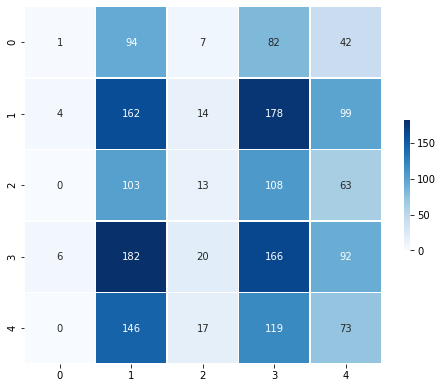

In [124]:
import seaborn as sns
plt.figure(figsize = (8,8))
ax = sns.heatmap(confus,square=True,cbar_kws={"shrink": 0.3}, linewidths = 0.5,annot=True, cmap="Blues",fmt="d")
ax.set_xticklabels(ax.get_xticklabels())

In [125]:
print(dict(pd.Series(y_test).value_counts()))

{3.0: 466, 1.0: 457, 4.0: 355, 2.0: 287, 0.0: 226}


In this confusion matrix on testing data set: 
- Children's literature is the class being predicted wrong the most, followed by Mystery. The model correctly predicted 1 of the 226 actual Children's literature and correctly predicted 13 of the 287 actual Mystery. 
- The highest accurate predictions belong to Novel (with correctly predicted 166 of the 466 actual ones), and Fantasy (with correctly predicted 162 of the 457 actual ones).

## Gaussian Naive Bayes classifier

In [138]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
# Create and training a Gaussian Naive Bayes classifier model
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

# Use the model to predict testing data
y_pred2 = clf_GNB.predict(X_test)
accuracy = accuracy_score(y_pred2, y_test)
print('Testing accuracy is: %.4f\n' % accuracy)

Testing accuracy is: 0.1865



In [139]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred2, average='weighted')
print('Testing precision score is: ', precision)

Testing precision score is:  0.20457392622637635


In [140]:
from sklearn.metrics import recall_score
recall =recall_score(y_test, y_pred2, average='weighted')
print('Testing recall score is: ', recall)

Testing recall score is:  0.18648799553322165


In [141]:
from sklearn.metrics import balanced_accuracy_score
bal_score = balanced_accuracy_score(y_test, y_pred2)
print('Testing balanced accuracy score is: ', bal_score)

Testing balanced accuracy score is:  0.19238937097444814


From all the score, we can see the Gaussian Naive Bayes classifier is also not a good classfier.

## KNeighbors Classifier

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Create and training a KNN classifier model
clf_knn = KNeighborsClassifier(n_neighbors = 10)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [143]:
# Use the model to predict testing data
y_pred3 = clf_knn.predict(X_test)

In [144]:
accuracy = accuracy_score(y_pred3, y_test)
print('Testing accuracy is: ', accuracy)

Testing accuracy is:  0.21049692908989392


In [145]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred3, average='weighted')
print('Testing precision score is: ', precision)

Testing precision score is:  0.20036753428947782


In [146]:
from sklearn.metrics import recall_score
recall =recall_score(y_test, y_pred3, average='weighted')
print('Testing recall score is: ', recall)

Testing recall score is:  0.21049692908989392


In [147]:
from sklearn.metrics import balanced_accuracy_score
bal_score = balanced_accuracy_score(y_test, y_pred3)
print('Testing balanced accuracy score is: ', bal_score)

Testing balanced accuracy score is:  0.19568700485518614


From all the score, we can see although the KNeighbors Classifier has very slightly improvement comapring to the Gaussian Naive Bayes, they are still not enought to perform accurate prediction.

In conclusion, the performance of the 3 classifers are not good enough to correctly classify the books into one of the five target genres including Children's literature, Science Fiction, Novel, Fantasy, Mystery. This can be explained because we have simplified the problem of genre prediction by assign just one text to label with two of these labels (eg. Science Fiction and Fantasy), and the limitation of features structure (eg. ",", "." ect.). As a result, there is need to employ more techniques to improve those models' performance.